In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import warnings
""" We use this in order for the results to be more visible """ 
warnings.filterwarnings('ignore')

In [3]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

We download the glove data set

In [4]:
# download glove files
!wget https://nlp.stanford.edu/data/glove.42B.300d.zip
!unzip glove.42B.300d.zip

--2022-12-18 09:10:00--  https://nlp.stanford.edu/data/glove.42B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip [following]
--2022-12-18 09:10:01--  https://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1877800501 (1.7G) [application/zip]
Saving to: ‘glove.42B.300d.zip’

glove.42B.300d.zip  100%[===================>]   1.75G  5.02MB/s    in 5m 53s  

2022-12-18 09:15:54 (5.08 MB/s) - ‘glove.42B.300d.zip’ saved [1877800501/1877800501]

Archive:  glove.42B.300d.zip
  inflating: glove.42B.300d.txt      


In [5]:
EMBEDDING_SIZE = 300
gloveFile = "glove.42B."+str(EMBEDDING_SIZE)+'d.txt'

We read the moview review data set and store it

In [6]:
import pandas as pd

df = pd.read_csv("/content/gdrive/MyDrive/AI2/project01/imdb-reviews.csv",sep='\t')

We implement the function that we use in order to prepare the data for prediction

In [7]:
def Preparation(dataframe):
  df = dataframe[['rating','review']]
  # Replace all rating values with either 1 or 0
  df = df.replace({
    'rating' : {
        1.0 : 0.0,
        2.0 : 0.0,
        3.0 : 0.0,
        4.0 : 0.0,
        7.0 : 1.0,
        8.0 : 1.0,
        9.0 : 1.0,
        10.0 : 1.0,  
    }
  })
  dummy_list = []

  # clean all stopwords and symbols from reviews using the clean function that we implemented
  text_column = df['review']
  for value in text_column.values:
    value = Clean(value)
    dummy_list.append(value)

  df['review'] = dummy_list

  # tokenize all reviews
  fixedReviews = Tokenization(df['review'])
  # apply stemming on all reviews
  fixedReviews = Stemming(fixedReviews)
  # lemmatize all reviews
  fixedReviews = Lemmatization(fixedReviews)

  df['review'] = fixedReviews

  return df

We implement a function that cleans up a review from all the stopwords and any symbol

In [8]:
import numpy as np
import re

stopwords = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags
                           "]+", flags=re.UNICODE)

def Clean(review):
    if type(review) == np.float:
        return ""
    temp = review.lower()
    temp = re.sub("'", "", temp) # to avoid removing contractions in english
    temp = re.sub("@[A-Za-z0-9_]+","", temp) # remove mentions
    temp = re.sub("#[A-Za-z0-9_]+","", temp) # remove hashtags
    temp = re.sub(r'http\S+', '', temp) # remove links
    temp = re.sub(r"www.\S+", "", temp) # remove links
    temp = re.sub('[()!?]', ' ', temp) # remove punctuations 
    temp = re.sub('\[.*?\]',' ', temp) # remove punctuations 
    temp = re.sub("[^a-z0-9]"," ", temp) # remove non-alphanumeric characters
    temp = temp.split() # split text
    temp = [w for w in temp if not w in stopwords] # remove stopwords
    temp = " ".join(word for word in temp) # re-create text
    emoji_pattern.sub(r'', temp) # remove emojis and emoticons
    return temp

The following is a function that implements the process of Tokenization

In [9]:
from nltk import sent_tokenize
from nltk import word_tokenize

def Tokenization(data):
  tokenizedReviews = []
  for value in data:
    value = nltk.sent_tokenize(value)
    tokenizedReviews.append(value)

  return tokenizedReviews

The following is a function that implements the process of Stemming

In [10]:
from nltk.stem.snowball import SnowballStemmer

def Stemming(data):
  stemmer = SnowballStemmer(language = "english")

  stemmedReviews = []
  for value in data:
    dummyList = []
    for word in value:
      word = stemmer.stem(word)
      dummyList.append(word)
    stemmedReviews.append(dummyList)

  return stemmedReviews

The following is a function that implements the process of Lemmatization

In [11]:
import nltk
from nltk.stem import WordNetLemmatizer 

def Lemmatization(data):
  lemmatizer = WordNetLemmatizer()

  lemmatizedReviews = []

  for value in data:
    value = ' '.join([lemmatizer.lemmatize(w) for w in value])
    lemmatizedReviews.append(value)

  return lemmatizedReviews

We use the preparation function that we implemented in order to get the data ready for the process

In [12]:
fixedDf = Preparation(df)

reviews = fixedDf['review'] #Keep everything but rating
ratings = fixedDf['rating'] #Only keep rating

In [13]:
fixedDf

,rating,review
0,1.0,thought quiet good movie fun watch liked best ...
1,1.0,wagon master unique film amongst john fords wo...
2,1.0,film near perfect film john ford made film mag...
3,0.0,gave 4 stars lot interesting themes many alrea...
4,1.0,movie really genuine random really hard find m...
...,...,...
45003,0.0,dont even know begin br br worth typing review...
45004,0.0,one worst movies saw 90s id often use benchmar...
45005,0.0,baldwin really stooped low make movies script ...
45006,0.0,liked watching mel gibson million dollar hotel...


We split the data in training and test set. Note for the grader: You can use the graders_data variable to store the data set you will need and then use the Preparation() function by just giving as input the variable. Then, you will only need to store the review column in the Y_train variable and the rating in the Y_test variable as implemented.

In [14]:
from sklearn.model_selection import train_test_split

graders_data = None

if(graders_data is not None):
  X_train = list(reviews)
  X_test = list(ratings)
  """ 
    Code needed in order to initialize Y_train and Y_test using graders_data 
    TODO: Use the Preparation function
  """
  graders_data = Preparation(graders_data)
  Y_train = list(graders_data['review'])
  Y_test = list(graders_data['rating'])
else:
  X_train, X_test, Y_train, Y_test = train_test_split(list(reviews), list(ratings), train_size=0.8)

We split both the training and the testing set into tokens

In [15]:
X_train_tokens = [sent.lower().split() for sent in X_train]
X_test_tokens = [sent.lower().split() for sent in X_test]

The following function is used in order to find the average vector of a review given as input

In [16]:
def findAverageVector(words, model, numFeatures):
    featureVec = np.zeros((numFeatures),dtype="float32")
    wordCount = 0.

    for word in words:
      try:
        wordFeature = model[word]
      except KeyError:  # if the word is not in the dictionary
        continue
      else:
        if wordFeature is not None:
            wordCount = wordCount + 1.
            featureVec = np.add(featureVec,wordFeature)
    if wordCount > 0:
      featureVec = np.divide(featureVec, wordCount)
    return featureVec


The following function is used in order to find the average feature vector for every text inside the "text" variable given as input

In [17]:
def findTextsFeatureVectors(texts, model, numFeatures):
    counter = 0
    textsFeatureVectors = np.zeros((len(texts),numFeatures), dtype='float32') 
    
    for text in texts:
        textsFeatureVectors[counter] = findAverageVector(text, model, numFeatures)
        counter = counter + 1
    return textsFeatureVectors

The following function is used in order to create an embedding dictionary using a glove file given as input

In [18]:
def createEmbeddingDict(gloveFile):
    embeddingDict = {}
    count = 0
    with open(gloveFile,'r') as f: 
        for line in f: 
          count += 1
          values=line.split()
          word = values[0] 
          vector = np.asarray(values[1:], 'float32') 
          if vector.size == EMBEDDING_SIZE:
            embeddingDict[word] = vector 
    return embeddingDict

We create the embedding dictionary from the glove file

In [19]:
embedding_dict =  createEmbeddingDict(gloveFile)

We create the train and test data feature vectors

In [20]:
trainDataVecs = findTextsFeatureVectors(X_train_tokens, embedding_dict, EMBEDDING_SIZE)
testDataVecs  = findTextsFeatureVectors(X_test_tokens, embedding_dict, EMBEDDING_SIZE)

We create a tensor for each of the train and test data

In [21]:
import torch

X_train_tensor = torch.tensor(trainDataVecs, dtype=torch.float)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.long)

X_test_tensor = torch.tensor(testDataVecs, dtype=torch.float)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.long)

The following is a class that represents the model that we are going to use



In [22]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, D_in, H1, H2, H3,D_out):
        super(Net, self).__init__()
        self.flatten = nn.Flatten()
        self.model_stack =  nn.Sequential(
                      nn.Linear(D_in, H1),          
                      nn.ReLU(),
                      nn.Dropout(0.5),
                      nn.Linear(H1, H2),
                      nn.ReLU(),
                      nn.Dropout(0.25),
                      nn.Linear(H2, H3),
                      nn.ReLU(), 
                      nn.Dropout(0.1),
                      nn.Linear(H3, D_out),
                      )


    def forward(self, x):
        x = self.flatten(x)
        logits = self.model_stack(x)
        return logits

We define the parameteres that we will need for our execution.
We use three layers with sizes 64, 32, 16 and one output layer with size 3. We use 100 training epochs and the learning rate is 0,0025. Then we initialize our model, we initialize our loss function and finally our optimizer.

In [23]:
D_in = X_train_tensor.shape[1]
H1 = 64
H2 = 32
H3 = 16
D_out = 3

TRAINING_EPOCHS = 100

learning_rate = 0.0025

nn_model = Net(D_in, H1, H2, H3,D_out)
loss_func = nn.CrossEntropyLoss()
nn_optimizer = torch.optim.SGD(nn_model.parameters(), lr=learning_rate,momentum=0.5)

We initialize the data loader for both our training and testing set

In [24]:
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

validation_dataset = torch.utils.data.TensorDataset(X_test_tensor, Y_test_tensor)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=16, shuffle=True)

The following function is used in order to train our model

In [25]:
from sklearn.metrics import f1_score

def train_model(model,criterion,trainLoader,validationLoader,optimizer,epochs = 200):
  train_loss = []
  valid_loss = []
  """ For every epoch ( by default 200 ) """
  for epoch in range(epochs):
    train_batch_losses = []
    validation_batch_losses = []
    correct = 0
    count = 0
    y_total_valid = []   # store the predictions of the the validation set
    y_total_predict_valid = []      # store the labels of the the validation set
    y_total_predict_train = []
    y_total_train = []
    
    """ We first set the model to training mode """
    model.train()

    for x_batch, y_batch in trainLoader:
      """ We delete any previously stored gradients in the optimizer """
      optimizer.zero_grad()
      z = model(x_batch)
      loss = criterion(z, y_batch)
      train_batch_losses.append(loss.data.item())
      """ We perform backpropagation starting from the loss calculated in this epoch """
      loss.backward()
      """ We update the model's weights based on the gradients calculated during backprop """
      optimizer.step()
      """ We get the prediction based on the maximum possibility """
      _, y_pred_tags = torch.max(z, dim = 1) 
      y_total_predict_train = y_total_predict_train+ list(y_pred_tags)
      y_total_train = y_total_train + (list(y_batch.detach().numpy()))

    """ We set the model to evaluation mode """
    model.eval()

    for x_batch, y_batch in validationLoader:
      z = model(x_batch)
      """ We compute the validation loss """
      loss = criterion(z, y_batch)
      validation_batch_losses.append(loss.data.item()) 
      """ We get the label prediction based on the maximum possibility """
      _, label = torch.max(z,1)
      """ We compute the total amount of predictions made """
      correct += (label==y_batch).sum().item() 
      count += len(y_batch)
      y_total_predict_valid = y_total_predict_valid+ list(label)
      y_total_valid= y_total_valid + list(y_batch.detach().numpy())

    """ We compute the validation accurace based on the total correct predictions """
    accuracy = 100*(correct/(count))
    """ We compute the train loss of the current epoch """
    current_train_loss = sum(train_batch_losses)/len(trainLoader)
    """ We store the train loss in order to be able to plot the loss curves """
    train_loss.append(current_train_loss)
    """ We compute compute the validation loss of this current epoch """
    current_valid_loss = sum(validation_batch_losses)/len(validationLoader)
    """ We store the validation loss in order to plot the loss curves """
    valid_loss.append(current_valid_loss)
    f1_score_train = f1_score(y_total_train,y_total_predict_train,average='weighted')
    f1_score_valid = f1_score(y_total_valid,y_total_predict_valid,average='weighted')
    print(f"Epoch {epoch:3}: Train Loss = {current_train_loss:.5f} | Validation Loss = {current_valid_loss:.5f} | Accuracy = {accuracy:.4f} | Train-f1 = {f1_score_train:.4f} | Valid-F1 = {f1_score_valid:.4f}")
  return model,train_loss,valid_loss

We train the model

In [26]:
trained_model, train_loss,valid_loss = train_model(nn_model,loss_func,train_loader,validation_loader,nn_optimizer,TRAINING_EPOCHS)

Epoch   0: Train Loss = 0.77554 | Validation Loss = 0.70182 | Accuracy = 49.7223 | Train-f1 = 0.4846 | Valid-F1 = 0.3304
Epoch   1: Train Loss = 0.70177 | Validation Loss = 0.69564 | Accuracy = 49.7112 | Train-f1 = 0.5007 | Valid-F1 = 0.3301
Epoch   2: Train Loss = 0.69721 | Validation Loss = 0.69379 | Accuracy = 50.2888 | Train-f1 = 0.5002 | Valid-F1 = 0.3365
Epoch   3: Train Loss = 0.69599 | Validation Loss = 0.69408 | Accuracy = 49.7112 | Train-f1 = 0.4982 | Valid-F1 = 0.3301
Epoch   4: Train Loss = 0.69526 | Validation Loss = 0.69403 | Accuracy = 49.7112 | Train-f1 = 0.5035 | Valid-F1 = 0.3301
Epoch   5: Train Loss = 0.69532 | Validation Loss = 0.69330 | Accuracy = 50.2888 | Train-f1 = 0.4940 | Valid-F1 = 0.3365
Epoch   6: Train Loss = 0.69460 | Validation Loss = 0.69321 | Accuracy = 49.7112 | Train-f1 = 0.5007 | Valid-F1 = 0.3301
Epoch   7: Train Loss = 0.69480 | Validation Loss = 0.69524 | Accuracy = 49.7112 | Train-f1 = 0.4997 | Valid-F1 = 0.3301
Epoch   8: Train Loss = 0.69426 

The following function is used in order to plot the loss curves

In [27]:
import matplotlib.pyplot as plt

def plotLossCurves(t_loss,v_loss,epochs = 100):
  x = list(range(1,epochs+1))
  plt.plot(x, t_loss, 'r',label='Train Loss')
  plt.plot(x, v_loss, 'g',label='Test Loss')
  plt.legend(loc='best')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Loss vs Epoch curves')
  plt.show()

We plot the loss curves

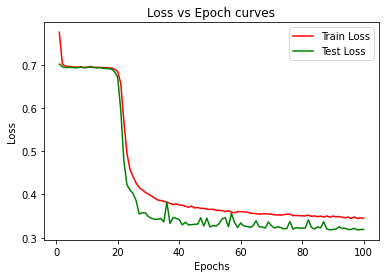

In [28]:
plotLossCurves(train_loss,valid_loss,TRAINING_EPOCHS) 

In [29]:
y_test = trained_model(X_test_tensor) 
y_test_numpy = y_test.detach().numpy()

We plot the ROC curves

 Accuracy: 86.04%
 f1 score: 86.03%
 Precision: 86.06%
 Recall: 86.04%
              precision    recall  f1-score   support

         0.0       0.85      0.87      0.86      4527
         1.0       0.87      0.85      0.86      4475

    accuracy                           0.86      9002
   macro avg       0.86      0.86      0.86      9002
weighted avg       0.86      0.86      0.86      9002



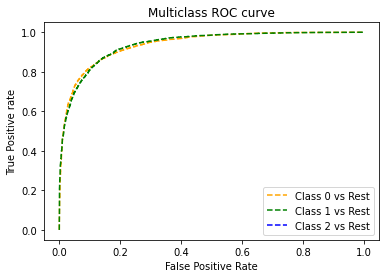

In [30]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
fpr = {}
tpr = {}
thresh ={}

numberOfClasses = 3

for i in range(numberOfClasses):    
    fpr[i], tpr[i], thresh[i] = roc_curve(Y_test_tensor, y_test_numpy[:,i], pos_label=i)
    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);  

""" We get the labels of the predictions based on the label with the maximum possibility for each instance """
_, y_test_tags = torch.max(y_test, dim = 1)
accuracy_countVec = accuracy_score(Y_test,y_test_tags) 
f1_score_countVec = f1_score(Y_test,y_test_tags,average='weighted')
print(" Accuracy: %.2f%%" %(accuracy_countVec*100))
print(" f1 score: %.2f%%" %(f1_score_countVec*100))
print(' Precision: %.2f%%' % (precision_score(Y_test, y_test_tags,average='weighted')*100)) 
print(' Recall: %.2f%%' % (recall_score(Y_test, y_test_tags,average='weighted')*100))
print(classification_report(Y_test, y_test_tags))

We split the data in training and test set. Note for the grader: You can use the graders_data variable to store the data set you will need and then use the Preparation() function by just giving as input the variable. Then, you will only need to store the review column in the Y_train variable and the rating in the Y_test variable as implemented.

In [31]:
from sklearn.model_selection import train_test_split

graders_data = None

if(graders_data is not None):
  X_train = list(reviews)
  X_test = list(ratings)
  """ 
    Code needed in order to initialize Y_train and Y_test using graders_data 
    TODO: Use the Preparation function
  """
  graders_data = Preparation(graders_data)
  Y_train = list(graders_data['review'])
  Y_test = list(graders_data['rating'])
else:
  X_train, X_test, Y_train, Y_test = train_test_split(list(reviews), list(ratings), train_size=0.8)

We split both the training and the testing set into tokens

In [32]:
X_train_tokens = [sent.lower().split() for sent in X_train]
X_test_tokens = [sent.lower().split() for sent in X_test]

We initialize the TfidfVectorizer, fit it with all the reviews in the training set and transform them

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3),max_features=300)
trainSet_transformed_tfidf = tfidf_vectorizer.fit_transform(X_train)
validationSet_transformed_tfidf = tfidf_vectorizer.transform(X_test)

We create a tensor for each of the train and test data

In [34]:
x_train_tensor = torch.tensor(trainSet_transformed_tfidf.toarray(), dtype=torch.float)
y_train_tensor = torch.tensor(Y_train, dtype=torch.long)

x_test_tensor = torch.tensor(validationSet_transformed_tfidf.toarray(), dtype=torch.float)
y_test_tensor = torch.tensor(Y_test, dtype=torch.long)

We define the parameteres that we will need for our execution. We use three layers with sizes 20, 10, 10 and one output layer with size 3. We use 100 training epochs and the learning rate is 0,1. Then we initialize our model, we initialize our loss function and finally our optimizer.

In [35]:
D_in = x_train_tensor.shape[1]
H1 = 20
H2 = 10
H3 = 10
D_out = 3

TRAINING_EPOCHS = 100

learning_rate = 0.1

nn_model = Net(D_in, H1, H2, H3,D_out)
loss_func = nn.CrossEntropyLoss()
nn_optimizer = torch.optim.SGD(nn_model.parameters(), lr=learning_rate)

We initialize the data loader for both our training and testing set

In [36]:
train_dataset = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(x_test_tensor, y_test_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True)

We train the model

In [37]:
trained_model, train_loss, test_loss = train_model(nn_model,loss_func,train_loader,test_loader,nn_optimizer,TRAINING_EPOCHS)

Epoch   0: Train Loss = 0.70704 | Validation Loss = 0.71080 | Accuracy = 49.5668 | Train-f1 = 0.5074 | Valid-F1 = 0.3285
Epoch   1: Train Loss = 0.58234 | Validation Loss = 0.47967 | Accuracy = 77.5272 | Train-f1 = 0.6912 | Valid-F1 = 0.7701
Epoch   2: Train Loss = 0.49863 | Validation Loss = 0.41985 | Accuracy = 80.9931 | Train-f1 = 0.7678 | Valid-F1 = 0.8094
Epoch   3: Train Loss = 0.46512 | Validation Loss = 0.42711 | Accuracy = 80.6487 | Train-f1 = 0.7889 | Valid-F1 = 0.8055
Epoch   4: Train Loss = 0.45588 | Validation Loss = 0.41911 | Accuracy = 80.6154 | Train-f1 = 0.7960 | Valid-F1 = 0.8055
Epoch   5: Train Loss = 0.44639 | Validation Loss = 0.40393 | Accuracy = 81.6485 | Train-f1 = 0.7977 | Valid-F1 = 0.8164
Epoch   6: Train Loss = 0.44037 | Validation Loss = 0.39916 | Accuracy = 81.7929 | Train-f1 = 0.8023 | Valid-F1 = 0.8179
Epoch   7: Train Loss = 0.43711 | Validation Loss = 0.39727 | Accuracy = 81.6596 | Train-f1 = 0.8028 | Valid-F1 = 0.8164
Epoch   8: Train Loss = 0.43580 

We plot the loss curves

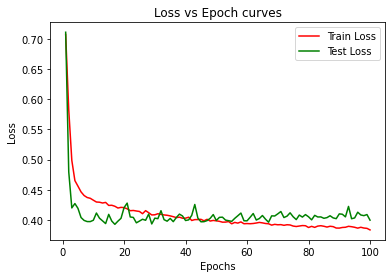

In [38]:
plotLossCurves(train_loss,test_loss,TRAINING_EPOCHS)

In [39]:
y_pred = trained_model(x_test_tensor)
y_pred_numpy = y_pred.detach().numpy()

We plot the ROC curves

 Accuracy: 50.01%
 f1 score: 50.00%
 Precision: 50.00%
 Recall: 50.01%
              precision    recall  f1-score   support

         0.0       0.50      0.52      0.51      4540
         1.0       0.50      0.48      0.49      4462

    accuracy                           0.50      9002
   macro avg       0.50      0.50      0.50      9002
weighted avg       0.50      0.50      0.50      9002



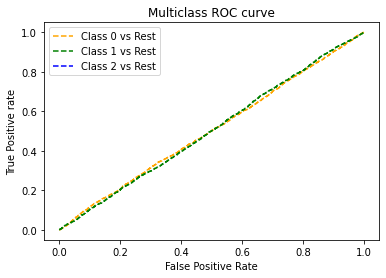

In [40]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

fpr = {}
tpr = {}
thresh ={}

numberOfClass = 3

for i in range(numberOfClass):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test_tensor, y_test_numpy[:,i], pos_label=i)
    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);  

""" We get the labels of the predictions based on the label with the maximum possibility for each instance """
_, y_pred_tags = torch.max(y_pred, dim = 1)
accuracy_countVec = accuracy_score(Y_test,y_test_tags) 
f1_score_countVec = f1_score(Y_test,y_test_tags,average='weighted')
print(" Accuracy: %.2f%%" %(accuracy_countVec*100))
print(" f1 score: %.2f%%" %(f1_score_countVec*100))
print(' Precision: %.2f%%' % (precision_score(Y_test, y_test_tags,average='weighted')*100))
print(' Recall: %.2f%%' % (recall_score(Y_test, y_test_tags,average='weighted')*100))
print(classification_report(Y_test, y_test_tags))